In [3]:
# https://blog.keras.io/building-autoencoders-in-keras.html

import os
import sys
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Input, UpSampling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard


In [2]:
# adds the gaussian noise based on the mean and the standard deviation 
def add_gaussian_noise(data):
  mean = (10, 10, 10)
  std = (50, 50, 50)
  row, col, channel = data.shape
  noise = np.random.normal(mean, std, (row, col, channel)).astype('uint8')
  return data + noise
  
def add_gaussian_to_dataset(data):
  count = 0
  end = len(data)
  output_data = []
  while count < end:
    output_data.append(add_gaussian_noise(data[count]))
    # output_data.append(add_gaussian_blur(data[count]))
    count+=1
  return np.array(output_data)

def add_gaussian_blur(data):
    dst = cv2.GaussianBlur(data, (35, 35), cv2.BORDER_DEFAULT)
    return dst

In [3]:
# clone sample images
if not os.path.isdir('dataAE'):
  !git clone https://github.com/avasalya/dataAE.git

image_dir = 'dataAE/images'
sys.path.append(image_dir)

images = os.listdir(image_dir)
print(images)


['8.jpg', '9.jpg', '14.jpg', '28.jpg', '15.jpg', '17.jpg', '16.jpg', '12.jpg', '13.jpg', '11.jpg', '10.jpg', '21.jpg', '20.jpg', '22.jpg', '23.jpg', '27.jpg', '26.jpg', '18.jpg', '24.jpg', '25.jpg', '19.jpg', '4.jpg', '5.jpg', '7.jpg', '6.jpg', '2.jpg', '3.jpg', '1.jpg']


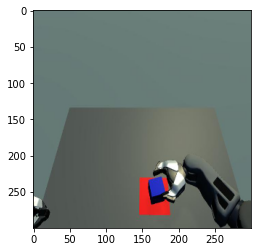

In [4]:
# create tensor batch of images
height = 300#480
width = 300#640

image_batch = []
for rgb in images:
  image = plt.imread(os.path.join(image_dir, rgb))
  image = cv2.resize(image, (width, height))
  # image = image / 255.0
  

  image_batch.append(image)
  

# stack images onto new channel
# image_batch = tf.stack(image_batch)
# print(image_batch.shape)
# print(type(image_batch))


plt.imshow(image_batch[3])


In [5]:
# resize the images
# image_batch = tf.image.resize(
#   image_batch, (320,320), method='nearest', preserve_aspect_ratio=False,
#   antialias=True, name=None)
  
# print(image_batch.shape)
# plt.imshow(image_batch[1,:])

In [6]:

# image_batch = image_batch/ 255

# #split test and train dataset
# ##USE SKLEARN  from sklearn.model_selection import train_test_split -- see mask-rcnn method
# train_ds, test_ds = tf.split(image_batch, num_or_size_splits=2, axis=0)
# tf.shape(train_ds).numpy()


ds = tf.stack(image_batch)
print(ds.shape)


(28, 300, 300, 3)


In [7]:

train_ds = ds[1:20,:]
test_ds = ds[20:,:]

print(train_ds.shape, test_ds.shape)



(24, 300, 300, 3) (3, 300, 300, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
(24, 300, 300, 3)


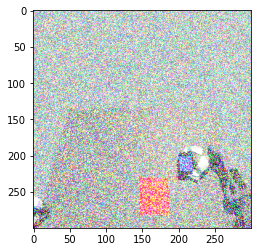

In [8]:
gaussian_train_ds = add_gaussian_to_dataset(train_ds)
gaussian_test_ds = add_gaussian_to_dataset(test_ds)

plt.imshow(gaussian_train_ds[3,:])
print(gaussian_train_ds.shape)



In [9]:
# rescaled data

# train_ds = train_ds.astype('float32') / 255.0
# test_ds = test_ds.astype('float32')  / 255.0

train_ds = train_ds / 255
test_ds = test_ds / 255

# # reduce images
gaussian_train_ds = gaussian_train_ds / 255.0 
gaussian_test_ds = gaussian_test_ds / 255.0



In [35]:
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)



def create_model():
  input_img = Input(shape=(width, height, 3)) 

  # Encoder
  x = Conv2D(128, (3, 3), activation='relu', padding='same')(input_img)
  x = MaxPooling2D((2, 2), padding='same')(x)
  x = BatchNormalization()(x)

  x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
  x = MaxPooling2D((2, 2), padding='same')(x)
  x = BatchNormalization()(x)
  
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  x = MaxPooling2D((2, 2), padding='same')(x)
  x = BatchNormalization()(x)

  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  x = MaxPooling2D((2, 2), padding='same')(x)
  x = BatchNormalization()(x)
  
  # x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
  # encoder = MaxPooling2D((2, 2), padding='same')(x)
  # encoder = layers.Flatten()(x),

  latent_dim = 128
  x = layers.Dense(latent_dim, activation='relu')(x)



  # Decoder
  x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)#encoder
  x = UpSampling2D((2, 2))(x)

  x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
  x = UpSampling2D((2, 2))(x)
  
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  x = UpSampling2D((2, 2))(x)
  
  x = Conv2D(32, (3, 3), activation='relu')(x)
  x = UpSampling2D((2, 2))(x)

  # x = Conv2D(8, (3, 3), activation='relu')(x)
  # x = UpSampling2D((2, 2))(x)

  decoder = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)


  model = keras.Model(input_img, decoder)
  # model.compile(optimizer='adam', loss='mse') #'binary_crossentropy'
  
  opt = keras.optimizers.Adam(learning_rate=0.001)
  # opt = keras.optimizers.SGD(learning_rate=0.01, momentum=0, nesterov=False)
  # model.compile(loss='mse', 
                      # optimizer=opt) #categorical_crossentropy

  model.compile(
    optimizer=opt,  # Optimizer
    # Loss function to minimize
    loss='mse',
    # List of metrics to monitor
    metrics=[tf.keras.metrics.Accuracy()])

  # model.summary()

  return model

In [37]:
gaussian_auto_encoder = create_model()
# gaussian_early_stop = EarlyStopping(monitor='loss', patience=3)
gaussian_history = gaussian_auto_encoder.fit(gaussian_train_ds,
                                            train_ds, 
                                            epochs=50, 
                                            batch_size=8,
                                            shuffle=True,
                                            validation_data=(gaussian_test_ds, test_ds),
                                            callbacks = tf.keras.callbacks.LearningRateScheduler(scheduler)
                                            # callbacks=[TensorBoard(log_dir='/tmp/autoencoder', histogram_freq=0, write_graph=False)]
                                            #, gaussian_early_stop])
                                            )

# https://www.tensorflow.org/tutorials/keras/save_and_load
# save model
now = datetime.now()
saveas = str('model_'+now.strftime('%d_%m_%y_%H_%M'))
# gaussian_auto_encoder.save(saveas)
tf.saved_model.save(gaussian_auto_encoder, saveas)


Epoch 1/50
3/3 [==============================] - 6s 2s/step - loss: 0.0172 - accuracy: 2.5077e-07 - val_loss: 0.0138 - val_accuracy: 0.0000e+00
Epoch 2/50
3/3 [==============================] - 6s 2s/step - loss: 0.0084 - accuracy: 1.5432e-07 - val_loss: 0.0140 - val_accuracy: 0.0000e+00
Epoch 3/50
3/3 [==============================] - 6s 2s/step - loss: 0.0066 - accuracy: 9.0664e-07 - val_loss: 0.0136 - val_accuracy: 0.0000e+00
Epoch 4/50
3/3 [==============================] - 6s 2s/step - loss: 0.0061 - accuracy: 7.9090e-07 - val_loss: 0.0132 - val_accuracy: 0.0000e+00
Epoch 5/50
3/3 [==============================] - 6s 2s/step - loss: 0.0053 - accuracy: 4.8225e-07 - val_loss: 0.0131 - val_accuracy: 0.0000e+00
Epoch 6/50
3/3 [==============================] - 5s 2s/step - loss: 0.0051 - accuracy: 8.4877e-07 - val_loss: 0.0134 - val_accuracy: 0.0000e+00
Epoch 7/50
3/3 [==============================] - 5s 2s/step - loss: 0.0048 - accuracy: 5.0154e-07 - val_loss: 0.0134 - val_accura

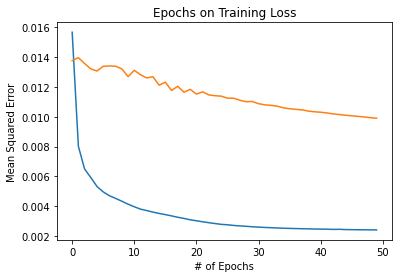

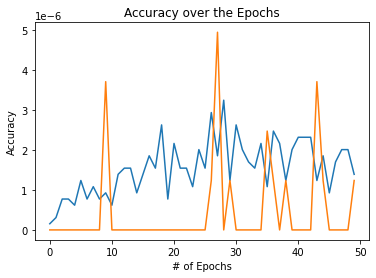

In [38]:
# plot training and validation losses

plt.plot(gaussian_history.epoch, gaussian_history.history['loss'])
plt.plot(gaussian_history.epoch, gaussian_history.history['val_loss'])
plt.title('Epochs on Training Loss')
plt.xlabel('# of Epochs')
plt.ylabel('Mean Squared Error')
plt.show()

plt.plot(gaussian_history.epoch, gaussian_history.history['accuracy'])
plt.plot(gaussian_history.epoch, gaussian_history.history['val_accuracy'])
plt.title('Accuracy over the Epochs')
plt.xlabel('# of Epochs')
plt.ylabel('Accuracy')
plt.show()


In [4]:
# evaluate the model on the test set
#load model
# saveas = 'model_07_06_21_18_47'

load_model = tf.keras.models.load_model(saveas)
result = load_model.predict(test_ds)
load_model.evaluate(test_ds, gaussian_test_ds)


# result = gaussian_auto_encoder.predict(gaussian_test_ds) #test_ds
# gaussian_auto_encoder.evaluate(test_ds, gaussian_test_ds)


NameError: name 'saveas' is not defined

In [1]:
n = 3
plt.figure(figsize=(15,10))
for idx in range(0,n):
    ax = plt.subplot(2,n,idx+1)
    plt.imshow(test_ds[idx])
    ax = plt.subplot(2,n,idx+1+n)
    plt.imshow(result[idx])

plt.show()

NameError: name 'plt' is not defined

In [ ]:
# ! tensorboard --logdir=/tmp/autoencoder --bind_all  --port 6000 